# Import Libraries

In [25]:
import warnings
warnings.filterwarnings("ignore")


import matplotlib.pyplot as plt
from IPython.display import HTML
import seaborn as sns
import pandas as pd
import numpy as np


from cv2 import imread


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet101V2
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


import pickle
from PIL import Image


import os
import random

# Set Theme

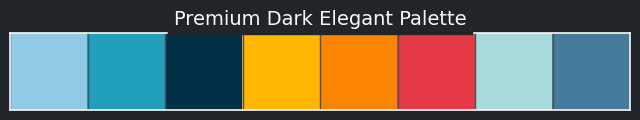

In [2]:
# Define a premium dark elegant color palette
dark_elegant_palette = [
    "#8ecae6",  # Light Blue Accent
    "#219ebc",  # Medium Blue
    "#023047",  # Deep Navy
    "#ffb703",  # Warm Yellow
    "#fb8500",  # Warm Orange
    "#e63946",  # Muted Red
    "#a8dadc",  # Soft Mint
    "#457b9d",  # Slate Blue
]

# Set a dark theme for Seaborn
sns.set_theme(
    style="darkgrid",              # Dark grid background
    palette=dark_elegant_palette,  # Custom color palette
    font="DejaVu Sans",
    rc={
        "axes.facecolor": "#212529",     # Dark background for axes
        "figure.facecolor": "#212529",   # Dark background for figure
        "axes.edgecolor": "#f8f9fa",     # Light axis lines
        "axes.labelcolor": "#f8f9fa",    # Light axis labels
        "text.color": "#f8f9fa",         # Light text
        "xtick.color": "#f8f9fa",        # Light tick labels
        "ytick.color": "#f8f9fa",
        "grid.color": "#495057",         # Muted gridlines
        "axes.titlesize": 16,
        "axes.labelsize": 14,
        "xtick.labelsize": 12,
        "ytick.labelsize": 12,
        "figure.figsize": (8, 5),
        "axes.linewidth": 1.2,
    }
)

# Apply the palette to Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=dark_elegant_palette)

# Preview the palette
sns.palplot(dark_elegant_palette)
plt.title("Premium Dark Elegant Palette", fontsize=14, color="#f8f9fa", backgroundcolor="#212529")
plt.show()

# Get Data

In [3]:
data_path = '/kaggle/input/garbage-classification-v2/garbage-dataset'

In [4]:
print(f"Number of class: {len(os.listdir(data_path))}")

Number of class: 10


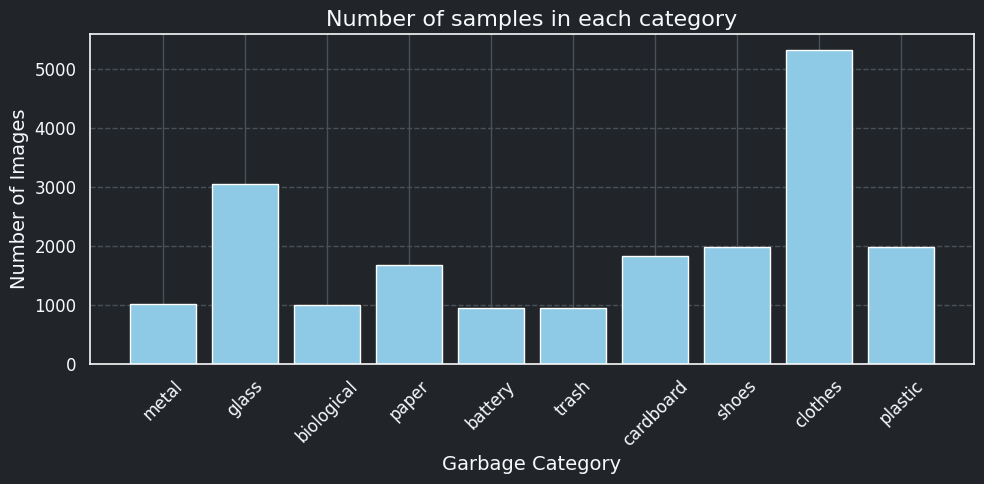

In [5]:
class_counts = { category: len(os.listdir(os.path.join(data_path, category))) for category in os.listdir(data_path) }

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.title("Number of samples in each category")
plt.xlabel("Garbage Category")
plt.ylabel("Number of Images")
plt.grid(axis="y", linestyle="--")
plt.tight_layout()
plt.show()

In [6]:
def plot_samples(path_of_dataset):
    classes = os.listdir(path_of_dataset)
    random_imgs = []
    for clas in classes:
        class_path = os.path.join(path_of_dataset, clas)
        random_img = random.choice(os.listdir(class_path))  
        image_path = os.path.join(class_path, random_img)
        random_imgs.append(image_path)

    plt.figure(figsize=(20, 15))  
    for i, image_path in enumerate(random_imgs):
        plt.subplot(2, 5, i+1) 
        img = imread(image_path)
        plt.imshow(img)
        plt.title(os.path.basename(os.path.dirname(image_path)))  
        plt.axis('off') 
    
    plt.tight_layout()  
    plt.show()

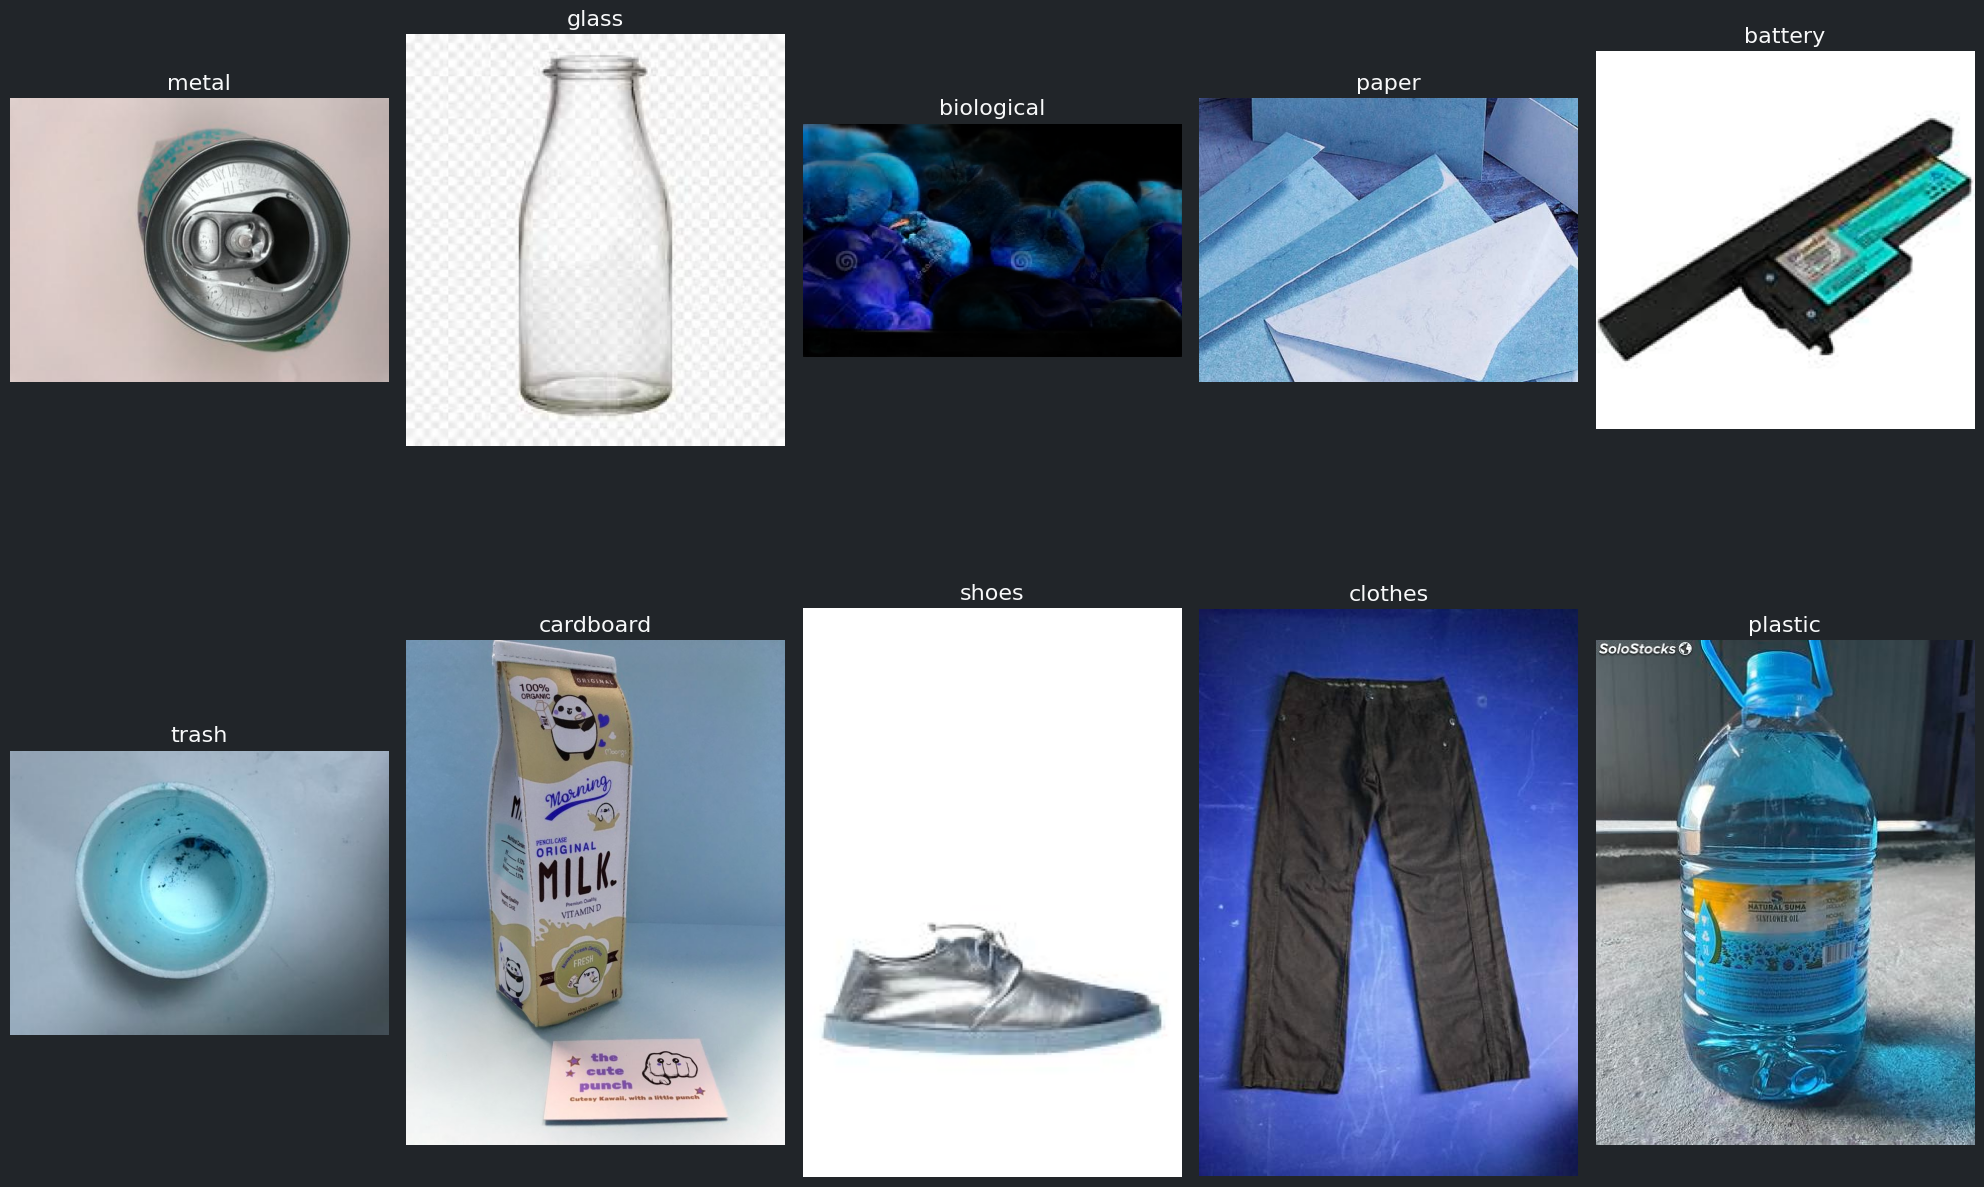

In [7]:
plot_samples(data_path)


In [8]:
def check_bad_images(base_path):
    bad_images = []
    
    
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('jpg', 'jpeg', 'png')):
                try:
                    img = Image.open(os.path.join(root, file))
                    img.verify()  # Will raise an exception if the image is corrupted
                except:
                    bad_images.append(os.path.join(root, file))
    
    print("Bad images:", bad_images)

In [9]:
check_bad_images(data_path)


Bad images: []


In [10]:
def get_shapes(base_path):
    image_shapes = []
    
    for clas in os.listdir(base_path):
        class_path = os.path.join(base_path, clas)
        for img_file in os.listdir(class_path)[:50]: 
            img_path = os.path.join(class_path, img_file)
            with Image.open(img_path) as img:
                image_shapes.append(img.size)
    
    # Convert to numpy array for statistics
    widths, heights = zip(*image_shapes)
    
    print(f"Average image width: {np.mean(widths):.2f}, height: {np.mean(heights):.2f}")
    print(f"Min size: {np.min(widths)}x{np.min(heights)} | Max size: {np.max(widths)}x{np.max(heights)}")

In [11]:
get_shapes(data_path)

Average image width: 379.55, height: 351.19
Min size: 144x109 | Max size: 2000x3556


In [12]:
target_size = (224, 224)
batch_size=32
seed=42

# Split Data

In [13]:
def create_datasets(data_path, target_size=(224, 224), batch_size=32, seed=42):
    """
    Creates train/val/test datasets 
    Returns: (train_gen, val_gen, test_gen, class_names)
    """
    # Get all image paths and labels
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_path))
    
    for class_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(data_path, class_name)
        for img_file in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(class_name)  # Using string labels for flow_from_dataframe
    
    # Create dataframe
    df = pd.DataFrame({'filename': image_paths, 'class': labels})
    
    # Split into train (70%), val (20%), test (10%)
    train_df, temp_df = train_test_split(
        df, 
        test_size=0.3, 
        random_state=seed,
        stratify=df['class']
    )
    
    val_df, test_df = train_test_split(
        temp_df,
        test_size=0.333,  # 0.333 * 0.3 = 0.1 (10%)
        random_state=seed,
        stratify=temp_df['class']
    )

    # Create generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        brightness_range=[0.9, 1.1],
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    # Flow from dataframe
    train_gen = train_datagen.flow_from_dataframe(
        train_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed
    )
    
    val_gen = val_test_datagen.flow_from_dataframe(
        val_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    test_gen = val_test_datagen.flow_from_dataframe(
        test_df,
        x_col='filename',
        y_col='class',
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )
    
    return train_gen, val_gen, test_gen, class_names

In [14]:
train, validation, test, class_names = create_datasets(data_path)

Found 13833 validated image filenames belonging to 10 classes.
Found 3954 validated image filenames belonging to 10 classes.
Found 1975 validated image filenames belonging to 10 classes.


# Modeling With ResNet 101V2

## Feature Extraction

In [31]:
base_model = ResNet101V2(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

171317808/171317808 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [32]:
x = base_model.output
x = GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)  

predictions = Dense(10, activation='softmax')(x) 
model_ResNet101V2= Model(inputs=base_model.input, outputs=predictions)



In [66]:
model_ResNet101V2.summary()

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 89,013,920 (339.56 MB)

 Trainable params: 23,061,898 (87.97 MB)

 Non-trainable params: 19,828,224 (75.64 MB)

 Optimizer params: 46,123,798 (175.95 MB)

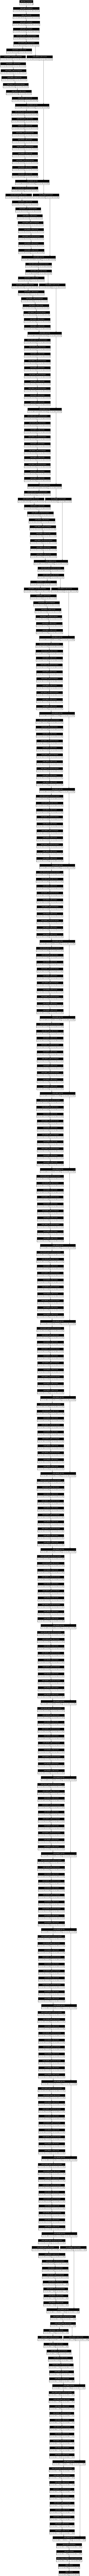

In [67]:
plot_model(
    model_ResNet101V2,
    to_file='model.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [34]:
optimizer = AdamW(learning_rate=1e-4)  # Higher learning rate

model_ResNet101V2.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [29]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [35]:
history_ResNet101V2 = model_ResNet101V2.fit(
    train,
    epochs=15,
    validation_data=validation,
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)

Epoch 1/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 311s 651ms/step - accuracy: 0.6687 - loss: 1.0433 - val_accuracy: 0.8869 - val_loss: 0.3436 - learning_rate: 1.0000e-04
Epoch 2/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 256s 591ms/step - accuracy: 0.8901 - loss: 0.3408 - val_accuracy: 0.9100 - val_loss: 0.2747 - learning_rate: 1.0000e-04
Epoch 3/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 257s 594ms/step - accuracy: 0.9098 - loss: 0.2801 - val_accuracy: 0.9186 - val_loss: 0.2520 - learning_rate: 1.0000e-04
Epoch 4/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 251s 579ms/step - accuracy: 0.9163 - loss: 0.2488 - val_accuracy: 0.9211 - val_loss: 0.2412 - learning_rate: 1.0000e-04
Epoch 5/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 250s 578ms/step - accuracy: 0.9274 - loss: 0.2196 - val_accuracy: 0.9216 - val_loss: 0.2366 - learning_rate: 1.0000e-04
Epoch 6/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 263s 607ms/step - accuracy: 0.9361 - loss: 0.1979 - val_accuracy: 0.9234 - val_loss: 0.2265 - learning_rate: 1.0000e-04
Epoch 7/15
433/433 ━━━━━━━━━━━━━━━━━━━━ 

In [37]:
test_loss, test_acc = model_ResNet101V2.evaluate(test, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 132ms/step - accuracy: 0.9480 - loss: 0.1956
Test Accuracy: 94.58%
Test Loss: 0.1978


In [60]:
def plot_training_curves(history):
    """
    Plots training & validation loss and accuracy.
    """
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Create plots
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig("training_curves.png")
    print("✅ Training curves saved as training_curves.png")
    plt.show()



✅ Training curves saved as training_curves.png


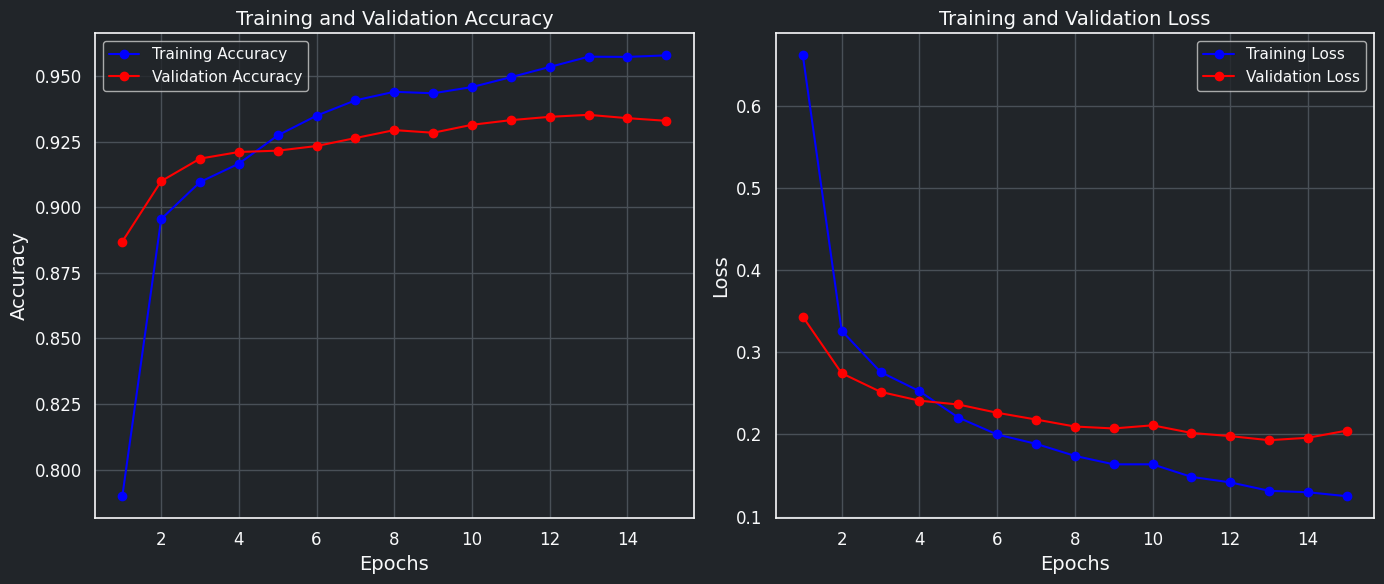

In [61]:
plot_training_curves(history_ResNet101V2)


In [40]:
def evaluate_model(model, test_gen, class_labels, save_prefix="model"):
    """
    Evaluates the model on a test set and saves evaluation artifacts.
    
    Args:
        model: Trained Keras model
        test_gen: Test data generator
        class_labels: List of class names
        save_prefix: Prefix for saved files (default 'model')
    """
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
    print(f"✅ Test Loss: {test_loss:.4f}")

    # Predict
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("\n📄 Classification Report:\n")
    print(report)

    # Save classification report
    report_file = f"{save_prefix}_classification_report.txt"
    with open(report_file, "w") as f:
        f.write(report)
    print(f"✅ Classification report saved to {report_file}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()

    cm_file = f"{save_prefix}_confusion_matrix.png"
    plt.savefig(cm_file)
    print(f"✅ Confusion matrix saved to {cm_file}")
    plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.9480 - loss: 0.1956
✅ Test Accuracy: 94.58%
✅ Test Loss: 0.1978
62/62 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step

📄 Classification Report:

              precision    recall  f1-score   support

     battery       0.95      0.96      0.95        94
  biological       0.97      0.98      0.98       100
   cardboard       0.94      0.95      0.94       183
     clothes       0.99      0.98      0.99       532
       glass       0.95      0.92      0.94       306
       metal       0.91      0.82      0.87       102
       paper       0.91      0.97      0.94       168
     plastic       0.90      0.91      0.90       198
       shoes       0.96      0.97      0.96       197
       trash       0.85      0.86      0.85        95

    accuracy                           0.95      1975
   macro avg       0.93      0.93      0.93      1975
weighted avg       0.95      0.95      0.95      1975

✅ Classification report saved to garbage_classifier_E

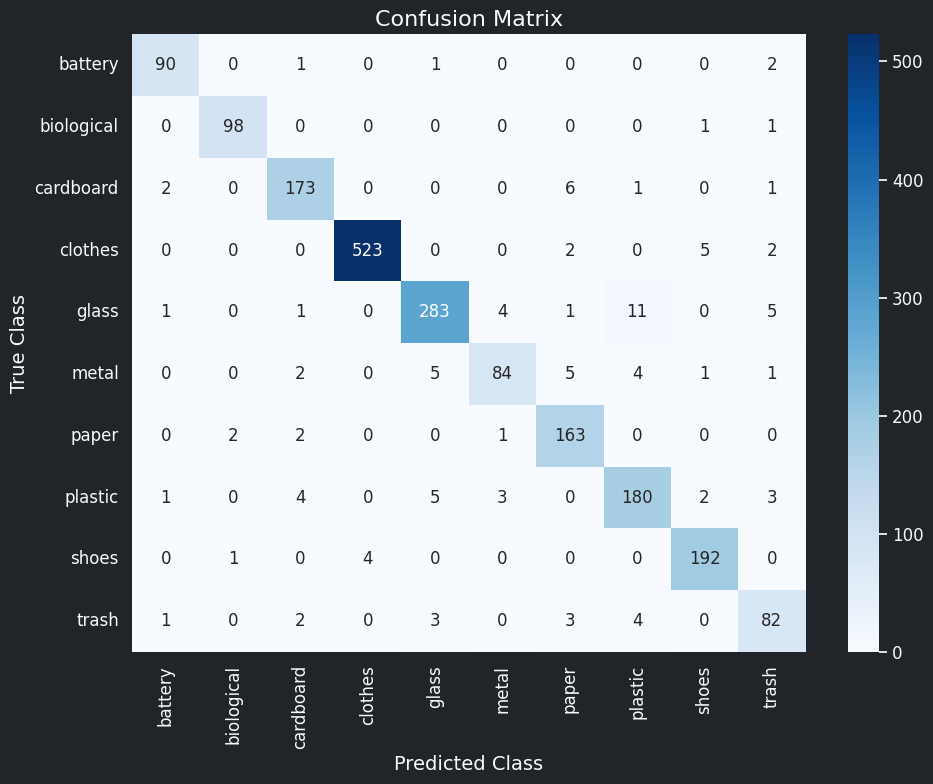

In [41]:
evaluate_model(model_ResNet101V2, test, class_names, save_prefix="garbage_classifier_EfficientB3")


## Fine Tuning

In [44]:
print(len(base_model.layers))


377


In [45]:
# Unfreeze top 30% of layers for fine-tuning
fine_tune_at = int(len(base_model.layers) * 0.7)  # freeze bottom 70%
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

In [48]:
model_ResNet101V2.compile(
              optimizer=AdamW(1e-5), 
              loss='categorical_crossentropy', 
              metrics=['accuracy']
)

In [49]:
finetuned_history_ResNet101V2 = model_ResNet101V2.fit(
    train,
    epochs=20,
    validation_data=validation,
    callbacks=[
        early_stopping,
        reduce_lr
    ]
)

Epoch 1/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 356s 680ms/step - accuracy: 0.8991 - loss: 0.3037 - val_accuracy: 0.9330 - val_loss: 0.2157 - learning_rate: 1.0000e-05
Epoch 2/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 265s 610ms/step - accuracy: 0.9551 - loss: 0.1581 - val_accuracy: 0.9390 - val_loss: 0.1935 - learning_rate: 1.0000e-05
Epoch 3/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 263s 607ms/step - accuracy: 0.9589 - loss: 0.1291 - val_accuracy: 0.9428 - val_loss: 0.1803 - learning_rate: 1.0000e-05
Epoch 4/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 260s 599ms/step - accuracy: 0.9701 - loss: 0.1040 - val_accuracy: 0.9454 - val_loss: 0.1737 - learning_rate: 1.0000e-05
Epoch 5/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 253s 585ms/step - accuracy: 0.9728 - loss: 0.0935 - val_accuracy: 0.9469 - val_loss: 0.1727 - learning_rate: 1.0000e-05
Epoch 6/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 258s 594ms/step - accuracy: 0.9780 - loss: 0.0773 - val_accuracy: 0.9492 - val_loss: 0.1643 - learning_rate: 1.0000e-05
Epoch 7/20
433/433 ━━━━━━━━━━━━━━━━━━━━ 

In [50]:
finetuned_test_loss, finetuned_test_acc = model_ResNet101V2.evaluate(test, verbose=1)
print(f"Test Accuracy: {finetuned_test_acc*100:.2f}%")
print(f"Test Loss: {finetuned_test_loss:.4f}")

62/62 ━━━━━━━━━━━━━━━━━━━━ 11s 178ms/step - accuracy: 0.9557 - loss: 0.1781
Test Accuracy: 95.54%
Test Loss: 0.1752


In [57]:
def plot_training_curves(history, save_prefix="model"):
    """
    Plots training & validation loss and accuracy.
    """
    # Extract data
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Create plots
    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(f"{save_prefix} training_curves.png")
    print("✅ Training curves saved as training_curves.png")
    plt.show()

✅ Training curves saved as training_curves.png


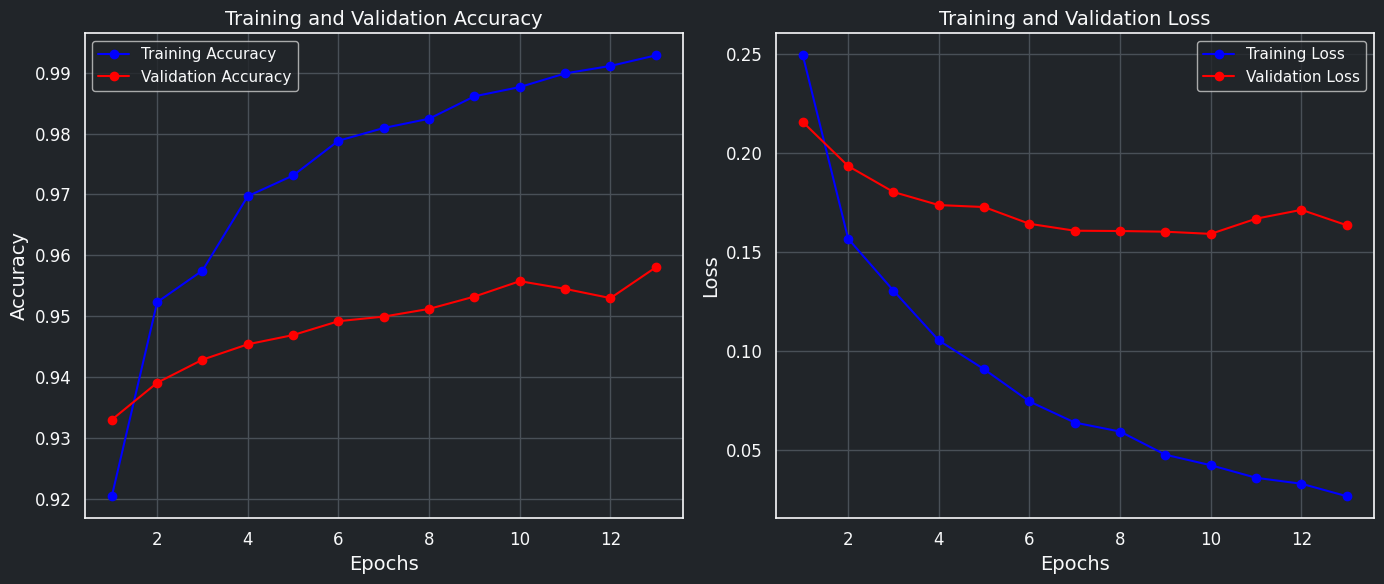

In [59]:
plot_training_curves(finetuned_history_ResNet101V2, save_prefix = 'fine_tuned')


In [53]:
def evaluate_model(model, test_gen, class_labels, save_prefix="model"):
    """
    Evaluates the model on a test set and saves evaluation artifacts.
    
    Args:
        model: Trained Keras model
        test_gen: Test data generator
        class_labels: List of class names
        save_prefix: Prefix for saved files (default 'model')
    """
    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_gen, verbose=1)
    print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
    print(f"✅ Test Loss: {test_loss:.4f}")

    # Predict
    y_pred_probs = model.predict(test_gen)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_gen.classes

    # Classification Report
    report = classification_report(y_true, y_pred, target_names=class_labels)
    print("\n📄 Classification Report:\n")
    print(report)

    # Save classification report
    report_file = f"{save_prefix}_classification_report.txt"
    with open(report_file, "w") as f:
        f.write(report)
    print(f"✅ Classification report saved to {report_file}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title("Confusion Matrix", fontsize=16)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.tight_layout()

    cm_file = f"{save_prefix}_confusion_matrix.png"
    plt.savefig(cm_file)
    print(f"✅ Confusion matrix saved to {cm_file}")
    plt.show()

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9557 - loss: 0.1781
✅ Test Accuracy: 95.54%
✅ Test Loss: 0.1752
62/62 ━━━━━━━━━━━━━━━━━━━━ 24s 259ms/step

📄 Classification Report:

              precision    recall  f1-score   support

     battery       0.97      0.97      0.97        94
  biological       0.96      0.97      0.97       100
   cardboard       0.95      0.97      0.96       183
     clothes       0.99      0.99      0.99       532
       glass       0.96      0.95      0.96       306
       metal       0.89      0.85      0.87       102
       paper       0.94      0.96      0.95       168
     plastic       0.91      0.91      0.91       198
       shoes       0.96      0.98      0.97       197
       trash       0.91      0.86      0.89        95

    accuracy                           0.96      1975
   macro avg       0.94      0.94      0.94      1975
weighted avg       0.96      0.96      0.96      1975

✅ Classification report saved to finetuned_garbage_cl

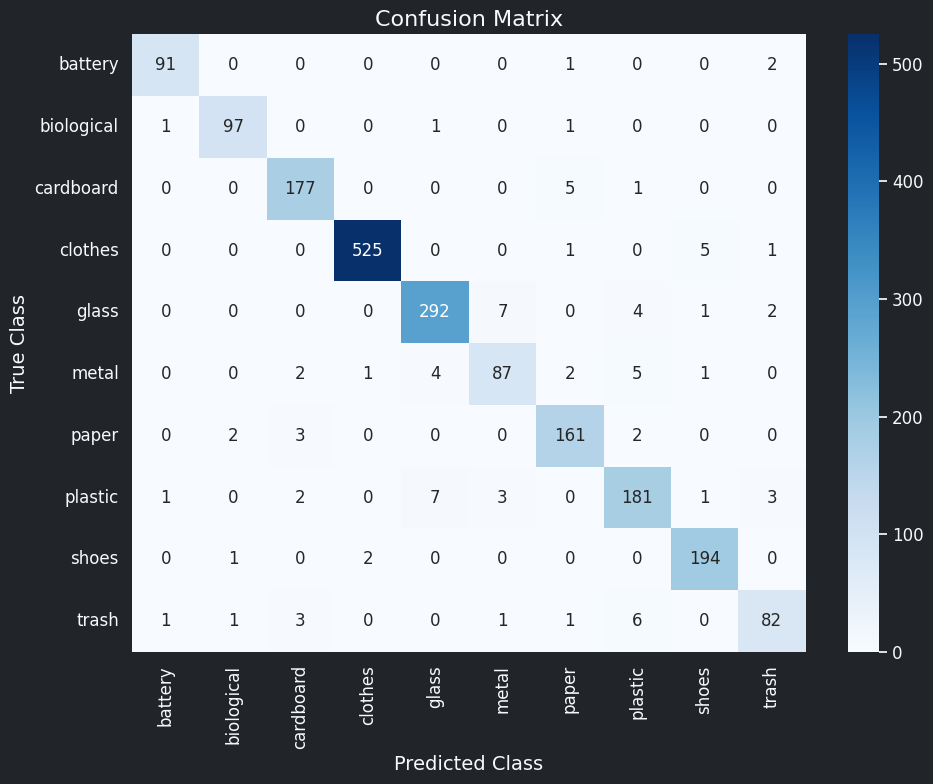

In [54]:
evaluate_model(model_ResNet101V2, test, class_names, save_prefix="finetuned_garbage_classifier")


## Saving Details

In [56]:
model_ResNet101V2.save("finetuned_garbage_classifier_model_ResNet101V2.keras")
print("✅ Model saved")

✅ Model saved


In [63]:
with open("finetuned_summary.txt", "w") as f:
    model_ResNet101V2.summary(print_fn=lambda x: f.write(x + "\n"))
print("✅ Model summary saved to finetuned_summary.txt")

✅ Model summary saved to finetuned_summary.txt


In [65]:
with open("finetuned_history.pkl", "wb") as f:
    pickle.dump(finetuned_history_ResNet101V2.history, f)
print("✅ Training history saved to finetuned_history.pkl")

✅ Training history saved to finetuned_history.pkl
